# YouTube Data API v3

### Python Libraries

In [98]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import networkx as nx

import collections

### Imported Scripts

In [101]:
    # api_key is stored in config.py
import config

    # Functions for making youtube_requests
import youtube_requests

    # Functions for data processing
import data_processing

    # Functions for creating a network graph    
#import networking

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [ ]:
youtube_channel_details_by_search('Corridor Crew',40)

Search method iterating using tokens to get more than 50 results. 

Uses requests to grab type=channel, part=snippet, order=?;

Creates an empty list, extends the list with the json's reponse items (50 at a time).

### Function to to return a list of maxResults parameter for each api request

 For a given number of requests and a specified batch_size, function will return a list of maxResults. 
 
 For example: (123, 50) returns [50,50,23]

In [2]:
def determine_max_result_list(n, batch_size):
    '''Function to return a list of max results parameters for a specific number of requests and batch_sizes.
    
    For example: (123,50) returns [50,50,23]'''
    # Logic to determine maxResults parameter
    if n%50 == 0:
        request_size_list = [batch_size]*(n//batch_size)
    # Determine a list of request sizes []
    else:
        request_size_list = [batch_size]*(n//batch_size) + [n%batch_size]
    return request_size_list

### Function to request a youtube search response for a given query and number of requests

Returns a list of dictionaries, each dictionary represents a specific channel and their subsequent details.<br>
Also create a channelid_list which comes from ```CHANNEL_LIST[0]['id']```

In [3]:
# Search for channels by a specific query
def youtube_request_search_channels(query, n):
    '''Returns a list of n channels that match the query.\n
    Uses /youtube/v3/search'''
    
    request_size_list = determine_max_result_list(n,50)
        
    # Empty list to store 50 items from each response
    channel_list = list()
    
    # Instantiate nextPageToken, when '' method interprets null
    nextPageToken = ''


    for request_size in request_size_list:
        
        # Create request object
        resp = requests.get(
            'https://www.googleapis.com/youtube/v3/search',
            params=dict(part='snippet', 
                        type='channel',
                        maxResults=request_size,
                        pageToken=nextPageToken,
                        q=query,
                        key=config.api_key)
        )
        assert resp.ok
        nextPageToken = json.loads(resp.content)['nextPageToken']
        channel_list.extend(json.loads(resp.content)['items'])
        #print(len(set(channel['id']['channelId'] for channel in channel_list)))
    return channel_list

### Function to request details on a list of channelIds

Returns a list of channel_resp json dictionaries stored in ```json.content['items']``` across all json responses (if requesting a list larger than 50)

In [4]:
# Get channel details and snippet
def youtube_request_channel_list(channelid_list):
    
    # Check for non-unique elements
    if len(channelid_list) != len(set(channelid_list)):
        print("There are non-unique elements in this list")
        
    # Determine request size list
    request_size_list = determine_max_result_list(len(set(channelid_list)),50)

    # Instantiate channel response list
    channel_resp_list = []
    
    # Set the start_index to 0
    start_index = 0
    # Loop 
    for request_size in request_size_list:
        
        # Debug
        #print(request_size_list, request_size, start_index, start_index+request_size)
        
        resp = requests.get(
            'https://www.googleapis.com/youtube/v3/channels',
            params=dict(part='contentDetails, snippet, statistics,\
                        brandingSettings, topicDetails, status, id, contentOwnerDetails',
                    id=channelid_list[start_index:start_index+request_size],
                    maxResults=50,
                    key=config.api_key)
        )
        # Increase the start_index
        start_index += request_size
        
        # Extend channel response list
        channel_resp_list.extend(json.loads(resp.content)['items'])
        
    return channel_resp_list

### Function to flatten dictionary nesting of channel resp for dataframe format

Returns a list of dictionaries where each key in the dictionary maps to a column of interest.<br>
As input takes a list of dictionaries where each dictionary is a specific 'item' from the original json.

In [ ]:
extract_channel_details()

In [6]:
def extract_channel_details(channels_details_items_list):
    # Instantite empty channels details list for new dictionary format
    channels_details_list = list()
    
    # Loop over each channel's json dictionary in details_list
    for channel in channels_details_items_list:
        # Instantiate new details dictionary; in series update the dictionary to include relevant details
        channel_details_dict = {}
        channel_details_dict.update(dict(id=channel['id']))
        channel_details_dict.update(channel['snippet'])
        channel_details_dict.update(channel['contentDetails'])
        #channel_details_dict.update(channel['topicDetails'])
        channel_details_dict.update(channel['status'])
        channel_details_dict.update(channel['statistics'])
        channel_details_dict.update(channel['brandingSettings']['channel'])
        
        # Append the added channel's new dictionary format to channel details list
        channels_details_list.append(channel_details_dict)
    return channels_details_list

--------------

# YouTube Channel Details by Search

Returns a details list of channels for a specific search query and number of requested results.

In [7]:
def youtube_channel_details_by_search(query, n):
    '''Returns a details list of channels for a specific search query and number of requested results.'''
    # Request n number of channels from a youtube search query
    channels_list = youtube_request_search_channels(query,n)

    # Retrieve Channel Ids from the list of dictionaries
    channels_id_list = [channel['snippet']['channelId'] for channel in channels_list]

    # Request details for all channels in a list of channelIds
    channels_details_items_list = youtube_request_channel_list(channels_id_list)

    # Extract channel details to a list of dictionaries for pandas
    #channels_details_list = extract_channel_details(channels_detail_items_list)
    
    return channels_details_items_list

In [ ]:
# Request n number of channels from a youtube search
CHANNELS_LIST = youtube_request_search_channels('Corridor Digital',20)

# Retrieve Channel Ids from the list of dictionaries
CHANNELS_ID_LIST = [channel['snippet']['channelId'] for channel in CHANNELS_LIST]

# Request details from each channel
CHANNEL_DETAILS_ITEMS_LIST = youtube_request_channel_list(CHANNELS_ID_LIST)

# Extract channel details to a list of dictionaries for pandas
CHANNELS_DETAILS_LIST = extract_channel_details(CHANNEL_DETAILS_ITEMS_LIST)

#### Return a detail_items list of channels associated to query and number of results

In [76]:
# Get 20 channels related to query through search
CHANNELS_DETAILS_ITEMS_LIST = youtube_channel_details_by_search("MSNBC", 20)
CHANNELS_DETAILS_ITEMS_LIST[0]

# Get n-degree network
corridor_2_network = youtube_channel_details_by_network([CHANNELS_DETAILS_ITEMS_LIST[0]],2)
nbc_2_network = youtube_channel_details_by_network([CHANNELS_DETAILS_ITEMS_LIST[0]],2)

In [49]:
# Checking for uniqueness
[channel['snippet']['title'] for channel in corridor_2_network]

['Corridor Cast',
 "Drinkin' Bros Podcast",
 'PowerfulJRE',
 'H3 Podcast',
 'Corridor',
 'Rooster Teeth',
 'Corridor Crew',
 'Bill Burr',
 'Good Mythical Morning',
 'Node',
 'Guillotine Channel',
 'h3h3Productions',
 'Rooster Teeth Trailers',
 'Cerberusarms',
 'Achievement Hunter',
 'Film Riot',
 'RackaRacka',
 'Coffee or Die',
 'Inside Gaming',
 'Lemacks Media',
 'The Slow Mo Guys',
 'GameFails',
 'Game Kids',
 'devinsupertramp',
 'Rooster Teeth Animation',
 'Funhaus',
 'SoKrispyMedia',
 'Shonduras',
 'LetsPlay',
 'DEATH BATTLE!',
 'Anna Akana',
 'Good Mythical MORE',
 'Game Attack',
 'Ethan and Hila',
 'Mythical Kitchen',
 'Ear Biscuits',
 'Nukazooka',
 'Free Range American Podcast',
 'The Film Look',
 'Rhett & Link',
 'BrandonJLa',
 'Black Rifle Coffee Company',
 'JRE Clips',
 'Linus Tech Tips',
 'H3 Podcast Highlights',
 'Joe Rogan',
 'RocketJump',
 'Mike Diva',
 'LetsPlay Community']

# Youtube Channel Details by Network

In [41]:
def extract_featured_channels(channels_details_items_list):
    ''' Function to extract a set of featured channelIds from a list of channelIds'''
    
    featured_channels_id_list = list()
    channels_wo_features_count = 0
    for channel in channels_details_items_list:

        if 'featuredChannelsUrls' in channel['brandingSettings']['channel']:
            featured_channels_id_list.extend(channel['brandingSettings']['channel']['featuredChannelsUrls'])
        else:
            channels_wo_features_count +=1
    print(f'{len(set(featured_channels_id_list))} neighbors; {channels_wo_features_count} out of {len(channels_details_items_list)} channels do not feature channels')
    return list(set(featured_channels_id_list))

In [31]:
a = {1,2,3}

In [32]:
b = {4,1,2,7}

In [33]:
a.difference(b.intersection(a))

{3}

In [45]:
b = b|

In [46]:
b

{1, 2, 3, 4, 7}

In [28]:
b.difference(a)

{4, 7}

In [47]:
def youtube_channel_details_by_network(channels_details_items_list, max_degree):
    
    network_channels_id_set = set([channel['id'] for channel in channels_details_items_list])
    
    # get a response for the list of channel Ids
    #channel_resp = youtube_request_channel_list(channelid_list)
    
    # Instantiate the output, a list of dictionaries, each dict represents a channel
    network_channels_items_list = []
    
    # Add our origin channel responses
    network_channels_items_list.extend(channels_details_items_list)
    
    # Instantiate a neighbors channel response
    neighbors_channels_items_list = channels_details_items_list
    
    # Loop over each degree of separate (breadth first search)
    for degree in range(1,max_degree+1):
        
        # Extract a list of featured channels ids
        neighbors_channels_id_set = set(extract_featured_channels(neighbors_channels_items_list))
        added_channels_id_set = neighbors_channels_id_set.difference(
                                    network_channels_id_set.intersection(
                                        neighbors_channels_id_set))
        
        network_channels_id_set = added_channels_id_set | network_channels_id_set
        print(added_channels_id_set)
        
        # Request channel details from Youtube using list of channel ids
        neighbors_channels_items_list = youtube_request_channel_list(list(added_channels_id_set))
        
        # Add n-degree channel details response
        network_channels_items_list.extend(neighbors_channels_items_list)
        
        
        
        
    return network_channels_items_list

In [ ]:
youtube_channel_details_by_network()

## NetworkX

In [93]:
# change function for producing positional argument.
POS = nx.drawing.layout.circular_layout(G)

In [95]:
def graph_channels(channel_response):
    
    # Dictionary comprehension to create channelId:featuredChannelUrls data structure
    channel_network = {channel['id']:channel['brandingSettings']['channel']['featuredChannelsUrls'] \
                       if 'featuredChannelsUrls' in channel['brandingSettings']['channel'] else [] \
                       for channel in channel_response}

    # Dict Comp to create channelId:Channelname data structure
    channel_names = {channel['id']:channel['snippet']['title'] \
                       if 'title' in channel['snippet'] else [] \
                       for channel in channel_response}
    
    G = nx.DiGraph(channel_network)
    plt.figure(figsize = (12,12))
    nx.draw_networkx(G,
                 with_labels=True,
                     pos=POS,
                 labels=channel_names,
                 font_size=12, font_color = 'red')
    return G

In [ ]:

# Dictionary comprehension to create channelId:featuredChannelUrls data structure
CHANNEL_NETWORK = {channel['id']:channel['brandingSettings']['channel']['featuredChannelsUrls'] \
                   if 'featuredChannelsUrls' in channel['brandingSettings']['channel'] else [] \
                   for channel in CHANNEL_DETAILS_LIST}

# Dict Comp to create channelId:Channelname data structure
CHANNEL_NAMES = {channel['id']:channel['snippet']['title'] \
                   if 'title' in channel['snippet'] else [] \
                   for channel in CHANNEL_DETAILS_LIST}


In [ ]:

CHANNEL_NETWORK = {channel['id']:channel['brandingSettings']['channel']['featuredChannelsUrls'] \
                   if 'featuredChannelsUrls' in channel['brandingSettings']['channel'] else [] \
                   for channel in CHANNEL_RESP}

CHANNEL_NAMES = {channel['id']:channel['snippet']['title'] \
                   if 'title' in channel['snippet'] else [] \
                   for channel in CHANNEL_RESP}

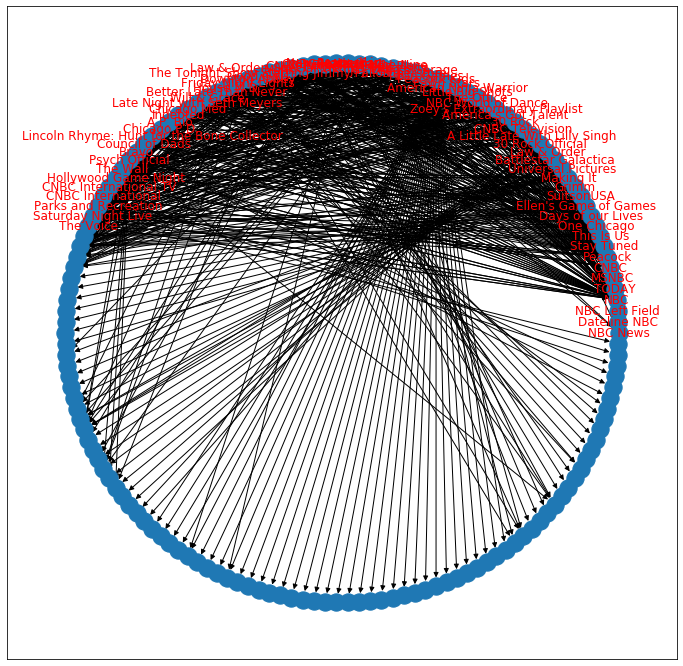

In [96]:
G = graph_channels(nbc_2_network)

In [83]:
def simple_page_rank(g):
    a = nx.adjacency_matrix(g)
    n, _ = a.shape
    v0 = np.ones(n) / n
    for i in range(20):
        v1 = a @ v0
        v1 /= v1.sum(0)
        print(np.linalg.norm(v1 - v0))
        v0 = v1
    return v1

In [84]:
V1 = simple_page_rank(G)

0.11046577423853872
0.05242464728712594
0.014307715257963444
0.0063618015545829675
0.0034120475996165323
0.00214087483186644
0.0013727497149246233
0.0008902319158076243
0.0005802327598989079
0.0003791874398191304
0.00024815112377424617
0.00016252222753484084
0.00010648724805271556
6.978972744437032e-05
4.57456742209315e-05
2.9988002445711336e-05
1.9659335812659428e-05
1.2888571945032245e-05
8.449866221591651e-06
5.539881855992672e-06


In [69]:
vector

UCNSeDrWRGxx5p2l3tj7RWQw    1.029939e-01
UCLK5icWTfKgw6I2HIku84vg    1.723899e-14
UCzQUP1qoWDoEbmsQxvdjxgQ    2.873164e-15
UCLtREJY21xRfCuEKvdki1Kw    5.009052e-06
UCsn6cjffsvyOZCZxvGoJxGg    1.333968e-01
                                ...     
UCNgSkSyLpwJckPsCcpDc2Ow    0.000000e+00
UC4VppoOwM5DzVHKWx5RJiCg    0.000000e+00
UCyoM9uxRbTtYoORWJPYWYyg    0.000000e+00
UC9gFih9rw0zNCK3ZtoKQQyA    0.000000e+00
UCb4G6Wao_DeFr1dm8-a9zjg    0.000000e+00
Length: 125, dtype: float64

In [87]:
DF['id']

0     UCeY0bbntWzzVIaj2z3QigXg
1     UCrp_UI8XtuYfpiqluWLD7Lw
2     UCF8wBg64pAc2ktRuPbW7qDg
3     UCqZQlzSHbVJrwrn5XvzrzcA
4     UCaXkIU1QidjPwiAYu6GcHjg
5     UCvJJ_dzjViJCoLf5uKUTwoA
6     UCTzTzEZYAiv_DkwYiYMGZMw
7     UCupvZG-5ko_eiXAupbDfxWw
8     UCrlrGIJcmgIsJQgOR1ev-ew
9     UCH5_L3ytGbBziX0CLuYdQ1Q
10    UCPm5gI2bm6Qb-P5tSCaL8GA
11    UCVcqEipLCQQ73RFYKayx54A
12    UC--c4SbAnFyweRv4vb26jgA
13    UCJdRZeIYRCOK-qA903R8Zdg
14    UCmbqdEtvqeYtgzeaH2rHwtQ
15    UCJEhA90uu7fG8qzGX9pehYg
16    UCdP-i2cMjScgfYRbqWSl45g
17    UCplNZVXfz6ntrQdtrmrewIw
18    UC2R3NadWhZe89Yg6JXF4rwA
19    UCFWz-RVDDuPdX-PImCjEaQQ
Name: id, dtype: object

In [91]:
DF.shape

(20, 29)

In [89]:
vector['UCF8wBg64pAc2ktRuPbW7qDg']

KeyError: 'UCF8wBg64pAc2ktRuPbW7qDg'

In [85]:
CHANNELIDS = list(G.nodes().keys())
vector = pd.Series(data = V1, index = CHANNELIDS)


In [86]:
DF['v1'] = DF['id'].map(lambda x:vector[x])

KeyError: 'UCF8wBg64pAc2ktRuPbW7qDg'

In [ ]:
len(CHANNELIDS)

In [ ]:
DF[['title','id','subscriberCount','viewCount','v1','featuredChannelsCount']].sort_values('v1', ascending=False).head(20)

# Connected Components

In [ ]:
import collections
def run():
    sizes = []
    ccs = []
    for cc in nx.connected_components(G.to_undirected()):
        ccs.append(cc)
        sizes.append(len(cc))
    print(sorted(sizes))
    return ccs#collections.Counter(sizes)

CCS = run()

In [ ]:
plt.figure(figsize = (12,12))
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)),
                 with_labels=False)
                 #labels=CHANNEL_NAMES,
                 #font_size=12, font_color = 'red')

In [ ]:
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)))

In [81]:
CHANNELS_DETAILS_LIST = extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Exploring the data

In [82]:
def create_dataframe(channel_details_list):
    df = pd.DataFrame(channel_details_list)
    df['videoCount'] = df['videoCount'].map(lambda x: int(x))
    df['commentCount'] = df['commentCount'].map(lambda x: int(x))
    df['viewCount'] = df['viewCount'].map(lambda x: int(x))
    df['subscriberCount'] = df['subscriberCount'].map(lambda x: int(x))
    df['featuredChannelsCount'] = df['featuredChannelsUrls'].apply(lambda x: 0 if type(x) == float else len(x))
    return df

features = ['id','title','description','customUrl','publishedAt','country','isLinked', 'viewCount', 'commentCount', 'subscriberCount',
           'hiddenSubscriberCount','keywords','showRelatedChannels','featuredChannelsUrls', 'featuredChannelsCount']

CHANNELS_DETAILS_LIST = extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)
DF = create_dataframe(CHANNELS_DETAILS_LIST)
DF.shape

(20, 29)

In [ ]:
DF.info()

In [ ]:
DF[features].sort_values(by='subscriberCount', ascending = False).head(5)

In [ ]:
sns.distplot(DF['subscriberCount'].map(lambda x: np.log(x+1)))

In [ ]:
sns.distplot(DF['viewCount'].map(lambda x: np.log(x+1)))

In [ ]:
plt.scatter(DF['subscriberCount'], DF['viewCount'])

In [ ]:
plt.barh(DF['title'], DF['subscriberCount'])